# Supervised Learning 

## Decision Trees

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [27]:
# Load dataset
df = pd.read_csv("Final_Dataset_Cleaned.csv")

# Drop unnecessary ID columns
df.drop(columns=['country_id', 'country_code', 'cause_id'], inplace=True)

country_series = df['country_name']

# One-hot encode cause_name → disease_*
df = pd.get_dummies(df, columns=['cause_name'], prefix='disease', drop_first=True)

df['country_name'] = country_series

# Dropping Target Variable

X = df.drop(columns=['mortality_rate'])
y = df['mortality_rate']

# Train Test Split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Target encoding for country_name

global_mean = y_train.mean()
smoothing = 10
kf = KFold(n_splits=5, shuffle=True, random_state=42)
country_te = pd.Series(index=X_train.index, dtype=float)

for train_idx, valid_idx in kf.split(X_train):
    fold_X = X_train.iloc[train_idx]
    fold_y = y_train.iloc[train_idx]
    
    stats = fold_y.groupby(fold_X['country_name']).agg(['mean', 'count'])
    smooth = (stats['mean'] * stats['count'] + smoothing * global_mean) / (stats['count'] + smoothing)
    
    country_te.iloc[valid_idx] = X_train['country_name'].iloc[valid_idx].map(smooth)

X_train['country_te'] = country_te.fillna(global_mean)

X_train = X_train.drop(columns=['country_name'])

original_country_train = df.loc[X_train.index, 'country_name']
train_stats = y_train.groupby(original_country_train).agg(['mean', 'count'])
smooth = (train_stats['mean'] * train_stats['count'] + smoothing * global_mean) / (train_stats['count'] + smoothing)

X_test['country_te'] = X_test['country_name'].map(smooth)
X_test['country_te'] = X_test['country_te'].fillna(global_mean)
X_test = X_test.drop(columns=['country_name'])

### Random Forest

In [28]:
# Random Forest Regression Model 
# Parameters: n_estimators = 100, ,max_depth = 10 

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Prediction Based train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Evaluation Metrics

# For Training Data 
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)
print("Train RMSE:", round(train_rmse, 2))
print("Train R²  :", round(train_r2, 3))

# For Testing Data 
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
print("Test RMSE :", round(test_rmse, 2))
print("Test R²   :", round(test_r2, 3)) 

Train RMSE: 66.94
Train R²  : 0.275
Test RMSE : 64.59
Test R²   : 0.265


                                            feature  importance
16                                disease_Neoplasms    0.264709
2                               physicians_per_1000    0.198371
27                                       country_te    0.124910
21  disease_Respiratory infections and tuberculosis    0.048993
0                                              year    0.041682
24                  disease_Substance use disorders    0.037263
18                 disease_Nutritional deficiencies    0.036894
23           disease_Skin and subcutaneous diseases    0.034409
14                disease_Musculoskeletal disorders    0.033801
4                     health_expenditure_per_capita    0.032671


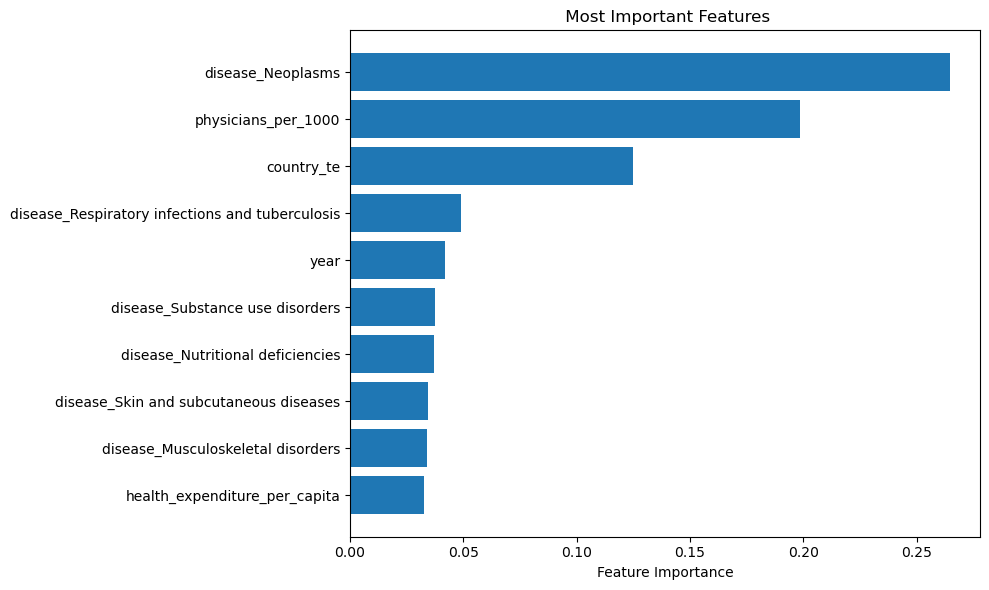

In [29]:
# Feature Importance
importances = rf.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Print the Top Features
top_features = feat_imp_df.head(10)
print(top_features)

# Plotting of Important Features 
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel("Feature Importance")
plt.title(f" Most Important Features")
plt.tight_layout()
plt.show()

#### Random Forest Hyper Tuning

In [42]:
# Parameters Used for Hypertuning 

param_grid = {
    'n_estimators': [100, 200, 300],         
    'max_depth': [10, 20, 30, 40],       
    'max_features': ['sqrt', 'log2'],   
    'min_samples_split': [2, 5],       
    'min_samples_leaf': [1, 2]          
}

# Using GridSearchCV with 5 fold Cross Validation 

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'  
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred_tuned = best_rf.predict(X_test)

rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("\n Best Random Forest Performance:")
print(f"  RMSE: {rmse_tuned:.3f}")
print(f"  R² Score: {r2_tuned:.3f}") 

/Users/sanro/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

 Best Random Forest Performance:
  RMSE: 40.824
  R² Score: 0.706


                                 feature  importance
27                            country_te    0.095543
16                     disease_Neoplasms    0.090905
2                    physicians_per_1000    0.060745
4          health_expenditure_per_capita    0.056778
3                          beds_per_1000    0.055778
6                         happinessscore    0.045048
5        percent_gdp_spent_on_healthcare    0.043603
1                       corruption_index    0.042386
9             disease_Digestive diseases    0.038101
8   disease_Diabetes and kidney diseases    0.036675


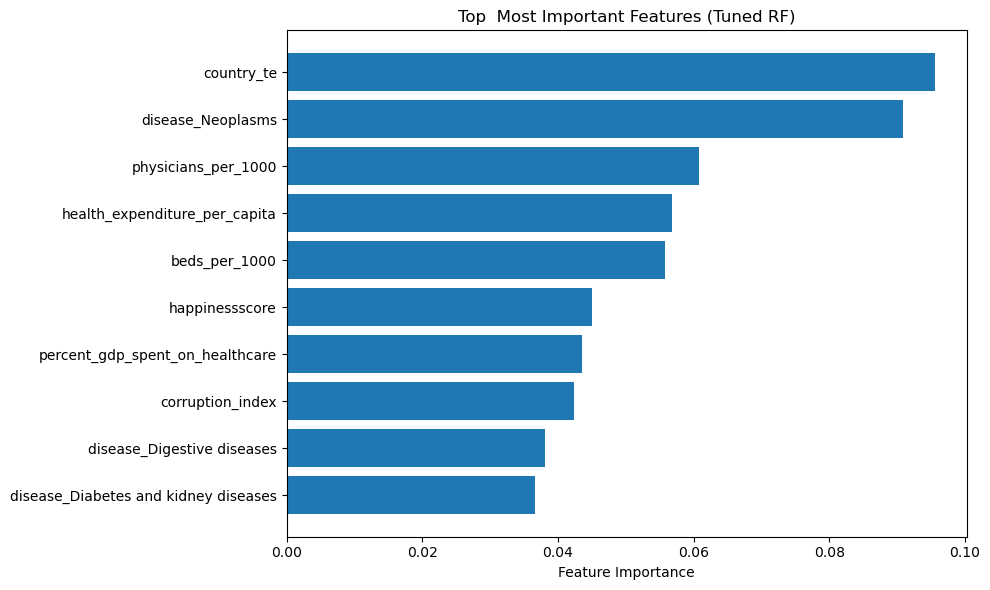

In [31]:
# Feature Importance
importances = best_rf.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Print the Top Features
top_features = feat_imp_df.head(10)

print(top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel("Feature Importance")
plt.title(f"Top  Most Important Features (Tuned RF)")
plt.tight_layout()
plt.show()

### Gradient Boosting 

In [32]:
# Gradient Boosting Regression Model 
# Parameter n_estimators=200, learning_rate=0.05, max_depth=5, min_samples_split=4, min_samples_leaf=2, random_state=42

gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print("\n Gradient Boosting Performance:")
print(f"  RMSE: {rmse_gb:.3f}")
print(f"  R² Score: {r2_gb:.3f}")


 Gradient Boosting Performance:
  RMSE: 57.805
  R² Score: 0.411


                                   feature  importance
16                       disease_Neoplasms    0.162185
2                      physicians_per_1000    0.149870
27                              country_te    0.112990
4            health_expenditure_per_capita    0.068804
3                            beds_per_1000    0.048363
13                disease_Mental disorders    0.036232
14       disease_Musculoskeletal disorders    0.034119
23  disease_Skin and subcutaneous diseases    0.033142
24         disease_Substance use disorders    0.030696
18        disease_Nutritional deficiencies    0.028945


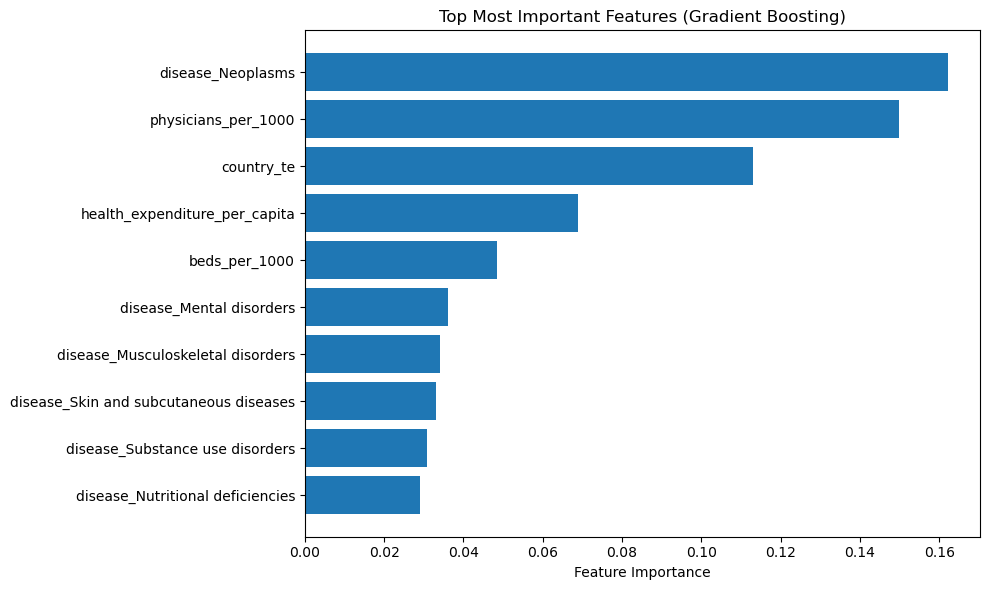

In [33]:
# Feature Importance 
gb_importances = gb.feature_importances_
feature_names = X_train.columns

gb_feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_importances
}).sort_values(by='importance', ascending=False)

# Top Features 
top_features = gb_feat_imp_df.head(10)

print(top_features)

# Ploting the Important Features 
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel("Feature Importance")
plt.title(f"Top Most Important Features (Gradient Boosting)")
plt.tight_layout()
plt.show()

#### Gradient Boosting HyperTuning 

In [43]:
# Parameters for HyperTuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Using GridSearchCV with 5 fold Cross Validation 
grid_search_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

grid_search_gb.fit(X_train, y_train)

best_gb = grid_search_gb.best_estimator_
print(" Best Parameters:", grid_search_gb.best_params_)

y_pred_gb_best = best_gb.predict(X_test)
rmse_gb_best = np.sqrt(mean_squared_error(y_test, y_pred_gb_best))
r2_gb_best = r2_score(y_test, y_pred_gb_best)

print("\n BestGradient Boosting Performance:")
print(f"  RMSE: {rmse_gb_best:.3f}")
print(f"  R² Score: {r2_gb_best:.3f}")

 Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}

 BestGradient Boosting Performance:
  RMSE: 42.158
  R² Score: 0.687


                                            feature  importance
2                               physicians_per_1000    0.107129
16                                disease_Neoplasms    0.106913
3                                     beds_per_1000    0.104017
27                                       country_te    0.093238
4                     health_expenditure_per_capita    0.048532
14                disease_Musculoskeletal disorders    0.032257
13                         disease_Mental disorders    0.031259
18                 disease_Nutritional deficiencies    0.031207
23           disease_Skin and subcutaneous diseases    0.031129
21  disease_Respiratory infections and tuberculosis    0.030969


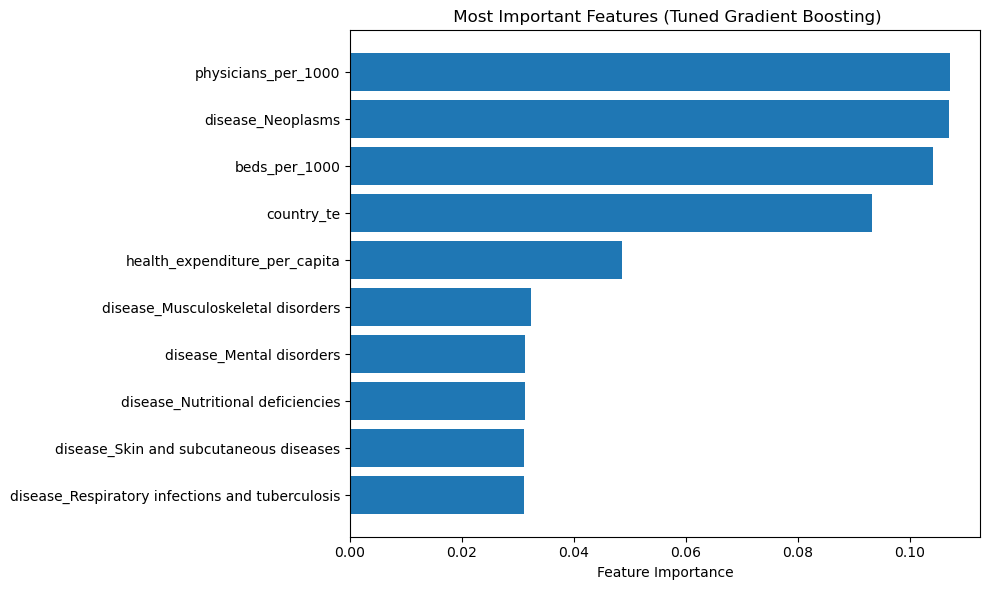

In [36]:
# Important Features 
gb_best_importances = best_gb.feature_importances_
feature_names = X_train.columns

gb_best_feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_best_importances
}).sort_values(by='importance', ascending=False)

# Print Top Features
top_features = gb_best_feat_df.head(10)

print(top_features)

# Plot the Top Features
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel("Feature Importance")
plt.title(f" Most Important Features (Tuned Gradient Boosting)")
plt.tight_layout()
plt.show()

### Comparison 

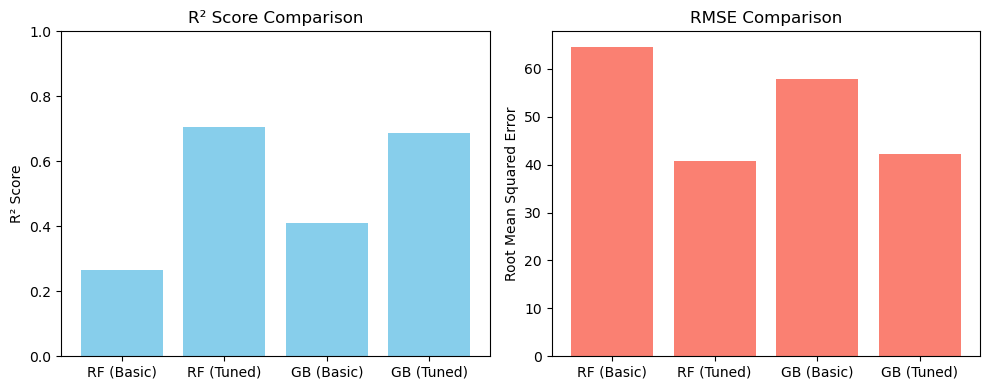

In [37]:
# Comparison of the Models RMSE and R2score 
model_names = ['RF (Basic)', 'RF (Tuned)', 'GB (Basic)', 'GB (Tuned)']
r2_scores = [test_r2, r2_tuned, r2_gb, r2_gb_best]
rmse_scores = [test_rmse, rmse_tuned, rmse_gb, rmse_gb_best]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(model_names, r2_scores, color='skyblue')
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.ylim(0, 1)  

plt.subplot(1, 2, 2)
plt.bar(model_names, rmse_scores, color='salmon')
plt.title("RMSE Comparison")
plt.ylabel("Root Mean Squared Error")

plt.tight_layout()
plt.show()

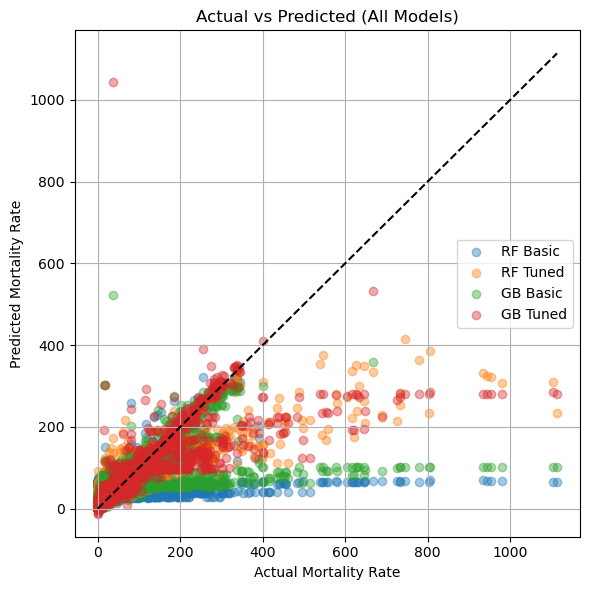

In [38]:
# Actual Vs Predictied Values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_preds, alpha=0.4, label='RF Basic')
plt.scatter(y_test, y_pred_tuned, alpha=0.4, label='RF Tuned')
plt.scatter(y_test, y_pred_gb, alpha=0.4, label='GB Basic')
plt.scatter(y_test, y_pred_gb_best, alpha=0.4, label='GB Tuned')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # perfect prediction line
plt.xlabel("Actual Mortality Rate")
plt.ylabel("Predicted Mortality Rate")
plt.title("Actual vs Predicted (All Models)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
# Function to plot Learning Curve 
def plot_learning_curve(estimator, X, y, cv=5, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1, shuffle=True, random_state=42
    )
    
    train_rmse = -np.mean(train_scores, axis=1)
    test_rmse = -np.mean(test_scores, axis=1)

    
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_rmse, 'o-', label="Training RMSE", color='blue')
    plt.plot(train_sizes, test_rmse, 'o-', label="Validation RMSE", color='orange')
    plt.xlabel("Training Set Size")
    plt.ylabel("Root Mean Squared Error")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

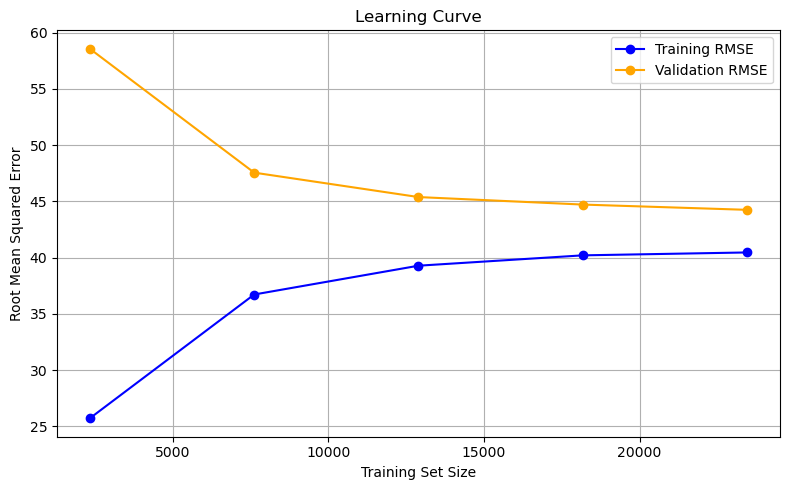

In [40]:
# Learning Curve for the Best Gradient boosting Model. 
plot_learning_curve(best_gb, X_train, y_train)

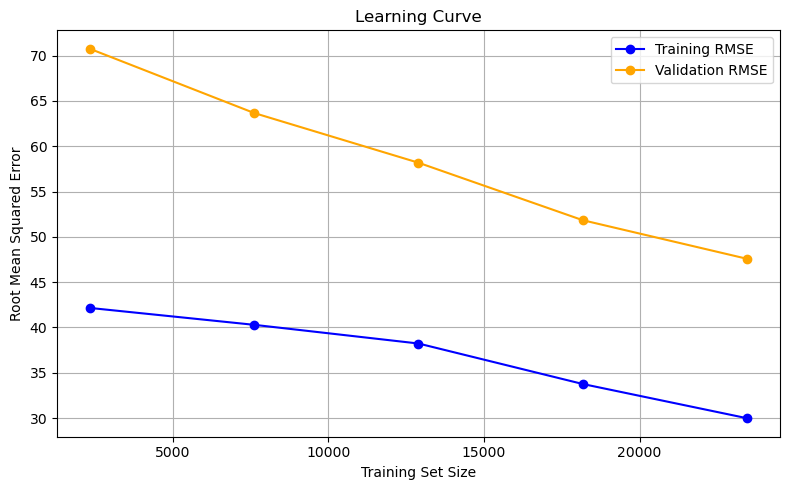

In [44]:
# Learning Curve for the Best Random Forest Model. 
plot_learning_curve(best_rf, X_train, y_train)

## Conclusion 

Using the Plots we can say that tuned random forest and tuned Gradient Boosting model performed well but when comparing the learning rate graphs we can say that Gradient Boosting model generalizes better